FBT now with a solenoid included

Will also add in the inverse transform to this notebook.

In [1]:
%matplotlib notebook

In [2]:
import sys
del sys.argv[1:]
from warp import *

# Warp
# Origin date: Fri, 15 Apr 2016 10:32:21 -0700
# Local date: Fri, 15 Apr 2016 10:32:21 -0700
# Commit hash: 557dfc1
# /usr/local/lib/python2.7/site-packages/warp/warp.pyc
# /usr/local/lib/python2.7/site-packages/warp/warpC.so
# Tue May 10 13:50:34 2016
# import warp time 0.546140909195 seconds
# For more help, type warphelp()


In [3]:
from warp.data_dumping.openpmd_diag import particle_diag
import numpy as np
import os
from copy import deepcopy
import matplotlib.pyplot as plt
from warp.lattice.solenoid import addnewsolenoid

In [4]:
diagDir = 'diags/hdf5'

def cleanupPrevious(outputDirectory = diagDir):
    if os.path.exists(outputDirectory):
        files = os.listdir(outputDirectory)
        for file in files:
            if file.endswith('.h5'):
                os.remove(os.path.join(outputDirectory,file))

cleanupPrevious()

setup()

# def setup():
# 	pass

Plot file name __main__.020.cgm


In [5]:
##########################################
### Create Beam and Set its Parameters ###
##########################################

top.lrelativ = True
top.relativity = 1

beam = Species(type=Electron, name='Electron') 
beam.ekin = 55e6 #KE = 2.5 MeV
derivqty() #Sets addition derived parameters (such as beam.vbeam)

matched_beta = 5.0

top.emitx    = 4.0*800e-6 / top.gammabar # geometric emittance: emit_full = 4 * emit_rms
top.emity    = 4.0*1e-6 / top.gammabar
beam.a0 = sqrt(top.emitx * matched_beta)
beam.b0 = sqrt(top.emity * matched_beta)
beam.ap0 = -1 * top.emitx * 0.0 / beam.a0
beam.bp0 = -1 * top.emity * 0.0 / beam.b0


beam.vthz = 0 #Sets the longitudinal thermal velocity (see iop_lin_002)
beam.ibeam = 0 # beam.ibeam/(top.gammabar**2) #Set correct current for relativity (see iop_lin_002)


top.npmax = 100000

w3d.distrbtn = "Gaussian0" 

w3d.cylinder = True  #Set True if running without envelope solver

In [6]:
#####################
### Setup Lattice ###
#####################


turnLength = 1.002
steps = turnLength / 1e-3
print "%s Steps from beginning to end" % steps

top.zlatstrt = 0 #  z of lattice start (added to element z's on generate).  
top.zlatperi = turnLength #turnLength # Lattice periodicity

top.dt = turnLength / steps / beam.vbeam  

mismatch = 1.5 #1.0 is no mismatch

solT = mismatch * 2 * beam.ekin / 299792458 / matched_beta # Matched solenoid strength

Sol1 = addnewsolenoid(1e-3, 1001e-3, ri = 1.0,maxbz = solT)


# start = Marker()
# end = Marker()

# transformLine = start + drift1 + Sol1 + drift2 + end

# madtowarp(transformLine)

1002.0 Steps from beginning to end


In [7]:
def FRBT(beta=5.0, alpha=0.0):
    """ 
        Transforms a matched flat beam to a round 'magnetized' beam.
    """

    gamma = (1. - alpha**2) / beta

    R = np.zeros([6,6],dtype='float64')
    R[0,0] = 1. + alpha
    R[0,1] = beta
    R[0,2] = 1. - alpha
    R[0,3] = -beta

    R[1,0] = -gamma
    R[1,1] = 1. - alpha
    R[1,2] = gamma
    R[1,3] = 1. + alpha

    R[2,0] = 1. - alpha
    R[2,1] = -beta
    R[2,2] = 1. + alpha
    R[2,3] = beta

    R[3,0] = gamma
    R[3,1] = 1. + alpha
    R[3,2] = -gamma
    R[3,3] = 1. - alpha

    R[4,4] = 2.
    R[5,5] = 2.

    R = 0.5 * R
    
    x = {}

    norm = {}
    for i in range(6):
        for j in range(6):
            norm[i,j] = 1.0
    norm[0,1] = norm[0,3] = norm[2,1] = norm[2,3] = 1./top.pgroup.uzp
    norm[1,0] = norm[1,2] = top.pgroup.uzp
    norm[3,0] = norm[3,2] = top.pgroup.uzp

    x = {}
    x[0] = np.copy(top.pgroup.xp)
    x[1] = np.copy(top.pgroup.uxp)
    x[2] = np.copy(top.pgroup.yp)
    x[3] = np.copy(top.pgroup.uyp)
    x[4] = np.copy(top.pgroup.zp)
    x[5] = np.copy(top.pgroup.uzp)

    print x[0].shape

    holding = []

    for i in range(6):
        val = 0
        for j in range(6):
            val += R[i,j] * x[j] * norm[i,j]
        
        holding.append(val)


    top.pgroup.xp = holding[0]
    top.pgroup.uxp = holding[1]
    top.pgroup.yp = holding[2]
    top.pgroup.uyp = holding[3]
    top.pgroup.zp = holding[4]
    top.pgroup.uzp = holding[5]
    
#     print "Transform!"

In [8]:
def IFRBT(beta=5.0, alpha=0.0):
    """ 
        Transforms a round 'magnetized' beam back to a flat beam.
    """

    gamma = (1. - alpha**2) / beta

    R = np.zeros([6,6],dtype='float64')
    R[0,0] = 1. + alpha
    R[0,1] = beta
    R[0,2] = alpha - 1.
    R[0,3] = beta

    R[1,0] = -gamma
    R[1,1] = 1. - alpha
    R[1,2] = -gamma
    R[1,3] = -1. - alpha

    R[2,0] = alpha - 1.
    R[2,1] = beta
    R[2,2] = 1. + alpha
    R[2,3] = beta

    R[3,0] = -gamma
    R[3,1] = -1. - alpha
    R[3,2] = -gamma
    R[3,3] = 1. - alpha

    R[4,4] = 2.
    R[5,5] = 2.

    R = 0.5 * R
    
    x = {}

    norm = {}
    for i in range(6):
        for j in range(6):
            norm[i,j] = 1.0
    norm[0,1] = norm[0,3] = norm[2,1] = norm[2,3] = 1./top.pgroup.uzp
    norm[1,0] = norm[1,2] = top.pgroup.uzp
    norm[3,0] = norm[3,2] = top.pgroup.uzp

    x = {}
    x[0] = np.copy(top.pgroup.xp)
    x[1] = np.copy(top.pgroup.uxp)
    x[2] = np.copy(top.pgroup.yp)
    x[3] = np.copy(top.pgroup.uyp)
    x[4] = np.copy(top.pgroup.zp)
    x[5] = np.copy(top.pgroup.uzp)

    print x[0].shape

    holding = []

    for i in range(6):
        val = 0
        for j in range(6):
            val += R[i,j] * x[j] * norm[i,j]
        
        holding.append(val)


    top.pgroup.xp = holding[0]
    top.pgroup.uxp = holding[1]
    top.pgroup.yp = holding[2]
    top.pgroup.uyp = holding[3]
    top.pgroup.zp = holding[4]
    top.pgroup.uzp = holding[5]

#     print "Inverse Transform!"

In [9]:
################################
### 3D Simulation Parameters ###
################################


top.prwall = pr1 = 0.14

#Set cells
w3d.nx = 128
w3d.ny = 128
w3d.nz = 1



#Set boundaries
w3d.xmmin = -0.10
w3d.xmmax =  0.10 
w3d.ymmin = -0.10 
w3d.ymmax =  0.10 
w3d.zmmin = -2e-3
w3d.zmmax =  2e-3

top.pboundxy = 0            # Absorbing Boundary for particles

top.ibpush   = 2            # set type of pusher to  vXB push without tan corrections
                            ## 0:off, 1:fast, 2:accurate

top.fstype = -1

In [21]:
############################
### Particle Diagnostics ###
############################

diagP0 = particle_diag.ParticleDiagnostic( period=1, top=top, w3d=w3d,
        species= { species.name : species for species in listofallspecies },
        comm_world=comm_world, lparallel_output=False, write_dir = diagDir[:-4] )

diagP = particle_diag.ParticleDiagnostic( period=1, top=top, w3d=w3d,
        species= { species.name : species for species in listofallspecies },
        comm_world=comm_world, lparallel_output=False, write_dir = diagDir[:-4] )

In [11]:
#################################
### Generate and Run PIC Code ###
#################################

package("wxy")
generate()
fieldsolve()



#Execute First Step

installbeforestep( diagP0.write )

installafterstep(FRBT)
step(1)
uninstallafterstep(FRBT)
uninstallbeforestep( diagP0.write )

step(1000)

installbeforestep(IFRBT)
installafterstep( diagP0.write )
step(1)

 ***  particle simulation package WXY generating
 ---  Resetting lattice array sizes
 ---  Allocating space for particles
 ---  Loading particles
 ---  Setting charge density
 ---  Allocating Win_Moments
 ---  Allocating Z_Moments
 ---  Allocating Lab_Moments
 ---  Allocating history arrays
 Atomic number of ion =  5.4858E-04
 Charge state of ion  = -1.0000E+00
 Initial X, Y emittances =  2.9457E-05,   3.6821E-08 m-rad
 Initial X,Y envelope radii  =  1.2136E-02,   4.2908E-04 m
 Initial X,Y envelope angles = -0.0000E+00,  -0.0000E+00 rad
 Input beam current =  0.0000E+00 amps
 Current density =  0.0000E+00 amps/m**2
 Charge density =  0.0000E+00 Coul/m**3
 Number density = -0.0000E+00
 Plasma frequency     =  0.0000E+00 1/s
    times dt          =  0.0000E+00
    times quad period =  0.0000E+00
 Plasma period        =  6.2832E+36 s
 X-, Y-Thermal Velocities     =  3.6382E+05,   1.2863E+04 m/s
    times dt                  =  1.2136E-06,   4.2908E-08 m
    times dt/dx, dt/dy (X, Y) =  7.

In [12]:
def readparticles(filename):
    """
    Reads in openPMD compliant particle file generated by Warp's ParticleDiagnostic class.

    Parameters:
        filename (str): Path to a ParticleDiagnostic output file.
    Returns:
        particle_arrays (dict): Dictionary with entry for each species in the file that contains an array
         of the 6D particle coordinates.
    """

    dims = ['momentum/x', 'position/y', 'momentum/y', 'position/z', 'momentum/z']
    particle_arrays = {}

    f = h5.File(filename, 'r')

    if f.attrs.get('openPMD') is None:
        print "Warning!: Not an openPMD file. This may not work."

    step = f['data'].keys()[0]
    species_list = f['data/%s/particles' % step].keys()

    for species in species_list:
        parray = f['data/%s/particles/%s/position/x' % (step, species)]
        for dim in dims:
            parray = np.column_stack((parray, f['data/%s/particles/%s/' % (step, species) + dim]))

        particle_arrays[species] = parray

    return particle_arrays

def convertunits(particlearray):
    """
    Putting particle coordinate data in good ol'fashioned accelerator units:
        x: m
        x': ux/uz
        y: m
        y': uy/uz
        z: m
        p: MeV/c

    """
    dat = deepcopy(particlearray)  # Don't copy by reference
    dat[:, 1] = dat[:, 1] / dat[:, 5]
    dat[:, 3] = dat[:, 3] / dat[:, 5]
    dat[:, 5] = dat[:, 5] / 5.344286E-22

    return dat


In [13]:
def svecplot(array):
    fig = plt.figure(figsize = (6,6))
    Q = plt.quiver(array[:,0],array[:,2],array[:,1],array[:,3])
    plt.quiverkey(Q,0.0, 0.92, 0.002, r'$2', labelpos='W')
    xmax = np.max(array[:,0])
    xmin = np.min(array[:,0])
    plt.xlim(1.5*xmin,1.5*xmax)
    plt.ylim(1.5*xmin,1.5*xmax)
    plt.show()

In [14]:
init = convertunits(readparticles('diags/hdf5/data00000000.h5')['Electron'])
fin = convertunits(readparticles('diags/hdf5/data00001002.h5')['Electron'])

In [15]:
def vortex_check(ia,fa):
    beta = 5.0
    fx = ia[:,0] + beta * ia[:,1]
    print fx.shape,ia.shape
    fxp = ia[:,1] - ia[:,0] / beta
    
    dif = np.array([(0.5*fx - fa[:,0]) / fa[:,0], (0.5*fxp - fa[:,1]) / fa[:,1]])
    
    return dif

<IPython.core.display.Javascript object>


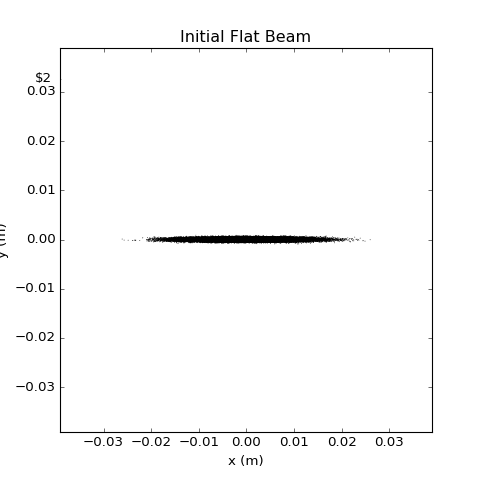

In [16]:
svecplot(init)
plt.title("Initial Flat Beam")
plt.xlabel("x (m)")
plt.ylabel("y (m)")

<IPython.core.display.Javascript object>


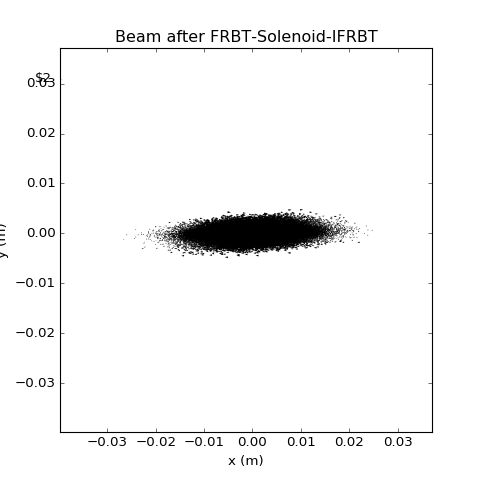

In [17]:
svecplot(fin)
plt.title("Beam after FRBT-Solenoid-IFRBT")
plt.xlabel("x (m)")
plt.ylabel("y (m)")

In [18]:
def calc_emittance(array):
    xemit = np.sqrt(np.average(array[:,0]**2) * np.average(array[:,1]**2) - np.average(array[:,0] * array[:,1])**2 )
    yemit = np.sqrt(np.average(array[:,2]**2) * np.average(array[:,3]**2) - np.average(array[:,2] * array[:,3])**2 )
    
    return xemit,yemit

In [19]:
epsx0,epsy0 = calc_emittance(init)
epsxf,epsyf = calc_emittance(fin)

In [20]:
print epsx0,epsy0
print epsxf,epsyf
print epsxf/epsx0, epsyf/epsy0

7.37519383e-06 9.21363923628e-09
7.0138128399e-06 2.43224369842e-07
0.95100047559 26.3982953537
